## 1. Module import

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## 2. Data

In [59]:
df = pd.read_csv('../data/tfidf_output_cleaned.csv',encoding='latin1')
#df = pd.read_csv('../data/preprocessing.csv')
df.head()



,Label,Message,imp_feature
0,0,"Go until jurong point, crazy.. Available only ...",go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",nah think goe usf live around though


### Split data into 2 parts to train and test

In [60]:
x = df.iloc[: , -1]
y = df.iloc[: , 0]
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

## 3.Model

In [61]:

from xgboost import XGBClassifier
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
x_train = tfidf.fit_transform(x_train)

xgb = XGBClassifier(learning_rate= 0.5, max_depth= 6).fit(x_train, y_train)

x_test = tfidf.transform(x_test)
y_pred_xgb = xgb.predict(x_test)

# from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold


# model = XGBClassifier()

# learning_rates = [0.5,0.6]
# max_depths = [6,7]
# # define grid search
# grid = dict(learning_rate=learning_rates,max_depth=max_depths)
# cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='f1',error_score=0)
# grid_result = grid_search.fit(x, y)
# # summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# means = grid_result.cv_results_['mean_test_score']
# stds = grid_result.cv_results_['std_test_score']
# params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))


# 4. Result

Precision :  0.9252336448598131
Recall :  0.7388059701492538
Accuracy Score :  0.9583333333333334
F1 Score :  0.8215767634854771

 [[890   8]
 [ 35  99]]



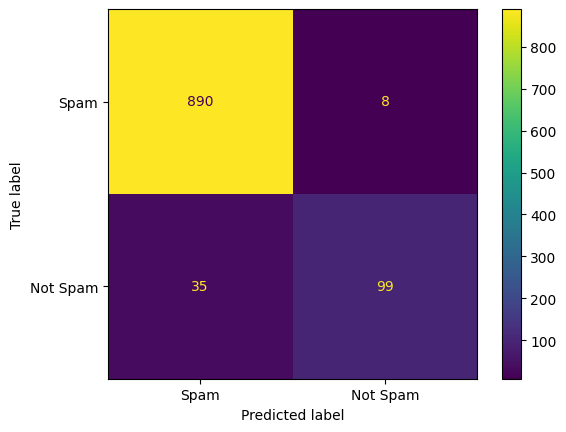

In [62]:
from sklearn.metrics import precision_score,recall_score,accuracy_score,f1_score,ConfusionMatrixDisplay,confusion_matrix
def perform(y_pred):
    print("Precision : ", precision_score(y_test, y_pred))
    print("Recall : ", recall_score(y_test, y_pred))
    print("Accuracy Score : ", accuracy_score(y_test, y_pred))
    print("F1 Score : ", f1_score(y_test, y_pred))
    print("\n", confusion_matrix(y_test, y_pred))
    print("")
    cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred), display_labels=['Spam', 'Not Spam'] )
    cm_display.plot()
    plt.show()
    
perform(y_pred_xgb)